## Denosing Autoencoder
```
Denosing autoencoder is a type of autoencoder that is trained to reconstruct the original input from a corrupted version of it by first corrupting the input and then learn to recover the original input.
```

In [1]:
# necessary imports
# add ../src to sys.path
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

import AE as ae

In [2]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor()])

# datasets
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


# data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

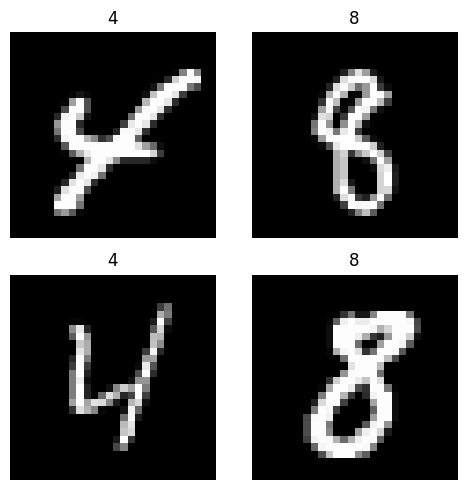

In [3]:
# visualize some data
def visualize_data(data, labels):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs = axs.flatten()
    for i in range(4):
        axs[i].imshow(data[i].squeeze(), cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# visualize some data
imgs, labels = next(iter(trainloader))
visualize_data(imgs, labels)

In [4]:
# corrupt the data with gaussian noise
def gaussian_noise(data, mean=0, std=0.1):
    noise = torch.randn(data.size()) * std + mean
    return data + noise

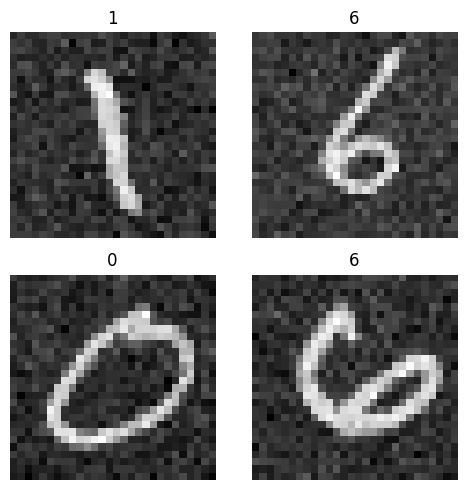

In [5]:
# visualize some data
imgs, labels = next(iter(trainloader))
imgs = gaussian_noise(imgs)
visualize_data(imgs, labels)

In [6]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# image size
img_size = imgs[0].shape[1]**2 # 28*28 = 784
# latent size
latent_size = 20

In [8]:
# define model
model = ae.AE(img_size, latent_size).to(device)

# pass some data through the model
imgs, labels = next(iter(trainloader)) #imgs.shape = [batch_size, 1, 28, 28], labels.shape = [128]

# flatten images
imgs = imgs.view(imgs.shape[0], -1).to(device) #imgs.shape = [128, 784]
recon_imgs, encoded_imgs = model(imgs)

print('Reconstructed images shape: ', recon_imgs.shape)
print('Encoded images shape: ', encoded_imgs.shape)

Reconstructed images shape:  torch.Size([128, 784])
Encoded images shape:  torch.Size([128, 20])


In [9]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# loss function
criterion = nn.MSELoss()

In [10]:
# training loop
epochs = 100

for epoch in trange(epochs):
    for i, (imgs, labels) in enumerate(trainloader):

        # corrupt images
        imgs = gaussian_noise(imgs)

        # flatten images
        imgs = imgs.view(imgs.shape[0], -1).to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        recon_imgs, encoded_imgs = model(imgs.to(device))

        # compute loss
        loss = criterion(recon_imgs, imgs)

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

    # print loss
    if epoch % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))

  1%|          | 1/100 [00:03<06:32,  3.96s/it]

Epoch: 0, Loss: 0.0331


 11%|█         | 11/100 [00:43<05:53,  3.97s/it]

Epoch: 10, Loss: 0.0170


 21%|██        | 21/100 [01:23<05:18,  4.03s/it]

Epoch: 20, Loss: 0.0168


 31%|███       | 31/100 [02:02<04:29,  3.90s/it]

Epoch: 30, Loss: 0.0172


 41%|████      | 41/100 [02:41<03:47,  3.86s/it]

Epoch: 40, Loss: 0.0164


 51%|█████     | 51/100 [03:20<03:10,  3.89s/it]

Epoch: 50, Loss: 0.0158


 61%|██████    | 61/100 [03:59<02:31,  3.89s/it]

Epoch: 60, Loss: 0.0155


 71%|███████   | 71/100 [04:37<01:50,  3.81s/it]

Epoch: 70, Loss: 0.0159


 81%|████████  | 81/100 [05:15<01:12,  3.82s/it]

Epoch: 80, Loss: 0.0157


 91%|█████████ | 91/100 [05:53<00:34,  3.82s/it]

Epoch: 90, Loss: 0.0149


100%|██████████| 100/100 [06:28<00:00,  3.89s/it]


In [17]:
# test model
original_imgs, labels = next(iter(testloader))
# corrupt images
noisy_imgs = gaussian_noise(original_imgs)
noisy_imgs = noisy_imgs.view(noisy_imgs.shape[0], -1).to(device)

# pass through model
recon_imgs, encoded_imgs = model(noisy_imgs)

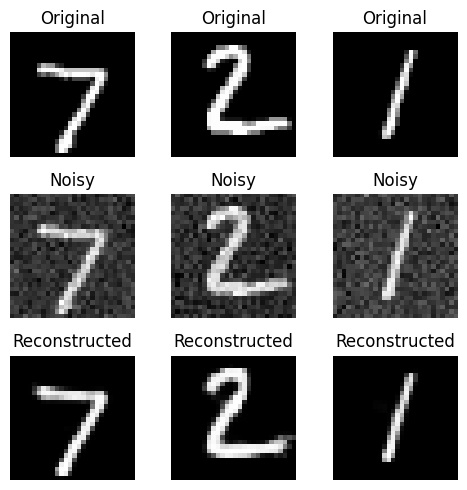

In [24]:
# visualize the original, noisy and reconstructed images. 3x3 grid
# first column: original images, second column: noisy images, third column: reconstructed images
plt.subplots(3, 3, figsize=(5,5))
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(original_imgs[i].detach().numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(3,3,i+4)
    plt.imshow(noisy_imgs[i].reshape(28,28).cpu().detach().numpy(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    plt.subplot(3,3,i+7)
    plt.imshow(recon_imgs[i].reshape(28,28).cpu().detach().numpy(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

```
Worked nicely. Good stuff!
```